In [241]:
import darts
from darts.utils.statistics import plot_acf
import pandas as pd 
import seaborn as sns
import numpy as np
import fancyimpute
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [245]:
#Import R Librares not found in Python
import rpy2
from rpy2 import robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
# Install packages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
packnames = ('tseries')
utils.install_packages(StrVector(packnames))
# Load packages
hunspell = importr('tseries')

In [39]:
#import sys
#!{sys.executable} -m pip install seaborn --user

In [40]:
#activate using R objects in Python
pandas2ri.activate()

Read the data
---

In [76]:
ts = pd.read_csv('ts_steps_P246.csv')
ts = ts.rename(columns={'date':'Date'})
ts['Date'] = pd.to_datetime(ts.Date)

Print the data
---

In [77]:
ts

,Date,steps
0,2019-05-08,1493
1,2019-05-09,5289
2,2019-05-10,9988
3,2019-05-11,8385
4,2019-05-12,1011
...,...,...
289,2020-02-26,1026
290,2020-02-27,1329
291,2020-02-28,6618
292,2020-02-29,11330


When the TS starts?
---

In [78]:
ts_min = min(ts.Date)

Show the minimum date
---

In [79]:
ts_min

Timestamp('2019-05-08 00:00:00')

When the TS end?
---

In [80]:
ts_max = max(ts.Date)

Show the maximum date
---

In [81]:
ts_max

Timestamp('2020-03-01 00:00:00')

How long is the data?
---

In [82]:
data_length = len(ts.Date.unique())

Show the length of the data
---

In [83]:
data_length

294

How long is the data?
---

In [84]:
ts_length = max(pd.to_datetime(ts.Date)) - min(pd.to_datetime(ts.Date))

Show how long is the date
---

In [85]:
ts_length

Timedelta('298 days 00:00:00')

Show the descriptive statistics
---

In [86]:
ts.steps.describe()

count      294.000000
mean      7625.676871
std       6198.166227
min        649.000000
25%       1703.500000
50%       7370.500000
75%      11071.750000
max      34167.000000
Name: steps, dtype: float64

Create Bar Chart
---

<Figure size 2000x2000 with 0 Axes>

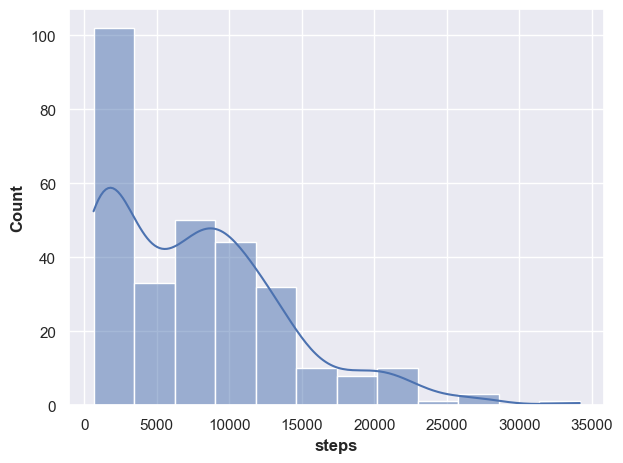

In [105]:
plt.figure(figsize=(20,20)) # this creates a figure 8 inch wide, 4 inch high

fig, ax = plt.subplots()
# plot with a horizontal orientation
sns.histplot(data=ts, x="steps", kde=True)
plt.tight_layout()
plt.show()

Create a time-series chart
---

/var/folders/bw/7qdh0ynx0c9bf8j9_sfpt8fw0000gn/T/ipykernel_56011/2163309051.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 2000x2000 with 0 Axes>

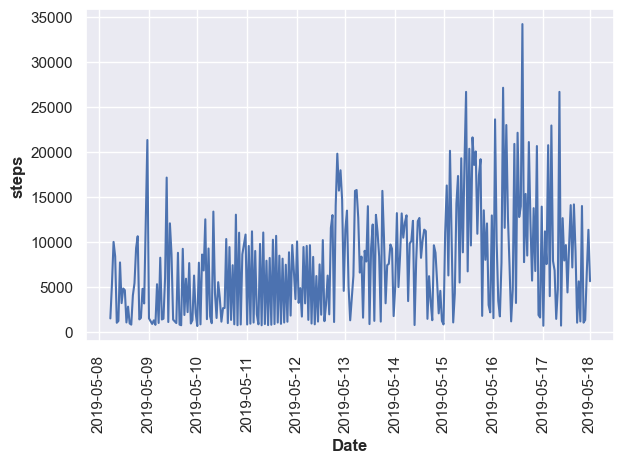

In [104]:
plt.figure(figsize=(20,20)) # this creates a figure 8 inch wide, 4 inch high

fig, ax = plt.subplots()
# plot with a horizontal orientation
sns.lineplot(x="Date", y="steps",data=ts)

# set the frequency for labelling the yaxis
freq = int(1)

# set the zlabels as the datetime data for the given labelling frequency,
# also use only the date for the label
ax.set_xticklabels(ts.iloc[::freq].Date.dt.date, rotation=90)
plt.tight_layout()
plt.show()

Check for duplicate dates
---

In [107]:
ids = ts['Date']
ts[ids.isin(ids[ids.duplicated()])].sort_values("Date")

,Date,steps


NAs in Time Series
---
Silent Missings
<br>
Most of the times, when dealing with TS the missing values are silent/hidden. In our example, if the number of steps for a given day is missing, the whole observation (row) is missing, and not only the value itself: we have a TS with daily step-count collected via a wearable device (e.g., FitBit). If on day x the device was switched off, we have a missing observation and the corresponding observation is not present in the TS. Therefore, before proceeding, we need to check if we have hidden missing observations."

In [108]:
ts_na = ts.sort_values("Date", ascending = True)
ts_na["diff_date"] = pd.to_datetime(ts_na.Date).diff().dt.days

In [109]:
ts_na

,Date,steps,diff_date
0,2019-05-08,1493,NaN
1,2019-05-09,5289,1.0
2,2019-05-10,9988,1.0
3,2019-05-11,8385,1.0
4,2019-05-12,1011,1.0
...,...,...,...
289,2020-02-26,1026,1.0
290,2020-02-27,1329,1.0
291,2020-02-28,6618,1.0
292,2020-02-29,11330,1.0


In [110]:
# find rows where date differece is more than 1 day
ts_na[ts_na.diff_date>1]

,Date,steps,diff_date
22,2019-05-31,21298,2.0
24,2019-06-03,881,2.0
38,2019-06-18,975,2.0
80,2019-07-31,10804,2.0
208,2019-12-07,1048,2.0


Create the missing dates
---

In [123]:
#Step 1: create a date range, preferably using the min date and max date as the limits
new_date_range = pd.date_range(start=ts_min, end=ts_max, freq="D")

In [124]:
#Print the new date range
new_date_range 

DatetimeIndex(['2019-05-08', '2019-05-09', '2019-05-10', '2019-05-11',
               '2019-05-12', '2019-05-13', '2019-05-14', '2019-05-15',
               '2019-05-16', '2019-05-17',
               ...
               '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01'],
              dtype='datetime64[ns]', length=299, freq='D')

In [131]:
#Step 2: using the current date column as the new index
df = ts.set_index(pd.DatetimeIndex(ts['Date']))

In [132]:
#print the new data
df

,Date,steps
Date,,
2019-05-08,2019-05-08,1493
2019-05-09,2019-05-09,5289
2019-05-10,2019-05-10,9988
2019-05-11,2019-05-11,8385
2019-05-12,2019-05-12,1011
...,...,...
2020-02-26,2020-02-26,1026
2020-02-27,2020-02-27,1329
2020-02-28,2020-02-28,6618


In [133]:
#step 3: to avoid conflict in column name, drop the date column since date is now used in the index
df = df.drop(columns = "Date")

In [134]:
# print the new data
df

,steps
Date,
2019-05-08,1493
2019-05-09,5289
2019-05-10,9988
2019-05-11,8385
2019-05-12,1011
...,...
2020-02-26,1026
2020-02-27,1329
2020-02-28,6618


In [135]:
#Step 3: generate a new data set with missing dates
df2 = df.reindex(new_date_range, fill_value=np.nan).reset_index().rename(columns={'index':'Date'})

In [136]:
#print the new dataset
df2

,Date,steps
0,2019-05-08,1493.0
1,2019-05-09,5289.0
2,2019-05-10,9988.0
3,2019-05-11,8385.0
4,2019-05-12,1011.0
...,...,...
294,2020-02-26,1026.0
295,2020-02-27,1329.0
296,2020-02-28,6618.0
297,2020-02-29,11330.0


In [138]:
#Test 1, check if there are some missing dates
missing_dates = df2.reset_index()
missing_dates["diff_date"] = pd.to_datetime(missing_dates.Date).diff().dt.days
missing_dates[missing_dates.diff_date>1]

,index,Date,steps,diff_date


In [139]:
#Test 2, check if there are nulls, note the number of nulls should be equal to the number of missing dates
df2[df2.steps.isna()]

,Date,steps
22,2019-05-30,NaN
25,2019-06-02,NaN
40,2019-06-17,NaN
83,2019-07-30,NaN
212,2019-12-06,NaN


Impute dataset with Kalman smoothing
---
Filling missing values by estimating a joint probability
distribution over the variables for each timeframe.

In [140]:
#Borrow a library from R
imputeTS = importr("imputeTS")
kalman_StructTs = robjects.r["na.kalman"]
kalman_auto_arima = robjects.r["na.kalman"]

In [146]:
estimate = kalman_StructTs(df2.steps, model = "StructTS")
estimate = pd.DataFrame(estimate, columns = ["steps"])
estimate

,steps
0,1493.0
1,5289.0
2,9988.0
3,8385.0
4,1011.0
...,...
294,1026.0
295,1329.0
296,6618.0
297,11330.0


In [147]:
df3 = df2.drop(columns = "steps")
df3["steps"] = pd.DataFrame(estimate)

In [148]:
df3

,Date,steps
0,2019-05-08,1493.0
1,2019-05-09,5289.0
2,2019-05-10,9988.0
3,2019-05-11,8385.0
4,2019-05-12,1011.0
...,...,...
294,2020-02-26,1026.0
295,2020-02-27,1329.0
296,2020-02-28,6618.0
297,2020-02-29,11330.0


In [149]:
df3[df3.steps.isna()]

,Date,steps


/var/folders/bw/7qdh0ynx0c9bf8j9_sfpt8fw0000gn/T/ipykernel_56011/1134462817.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 2000x2000 with 0 Axes>

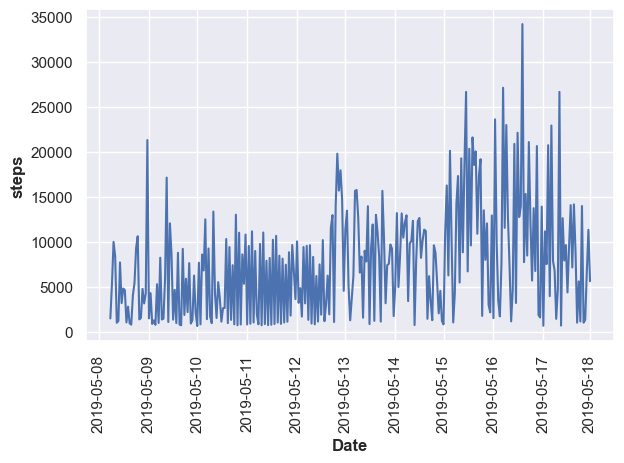

In [150]:
plt.figure(figsize=(20,20)) # this creates a figure 8 inch wide, 4 inch high

fig, ax = plt.subplots()
# plot with a horizontal orientation
sns.lineplot(x="Date", y="steps",data=df3)

# set the frequency for labelling the yaxis
freq = int(1)

# set the zlabels as the datetime data for the given labelling frequency,
# also use only the date for the label
ax.set_xticklabels(ts.iloc[::freq].Date.dt.date, rotation=90)
plt.tight_layout()
plt.show()

Autocorrelation
---
As we said, the autocorrelation is the correlation between one variable and the delayed copy of itself.
We can manually calculate the autocorrelation between the variable ‘steps’ and it delayed copy at lag 1

In [224]:
df4 = df3.set_index(pd.DatetimeIndex(df3['Date'])).drop(columns='Date')

Plotting ACF
---

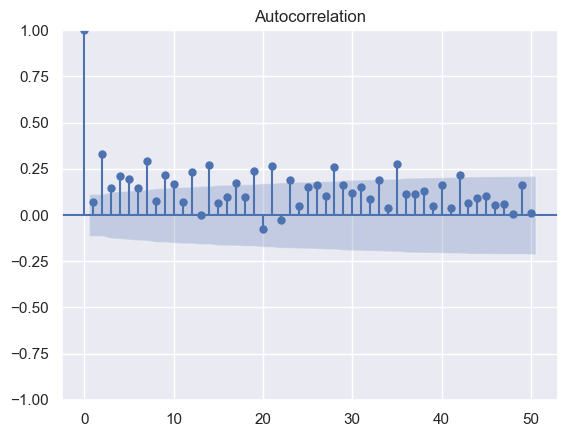

In [230]:
sm.graphics.tsa.plot_acf(df4.values.squeeze(), lags=50)
plt.show()

Plotting PACF
---

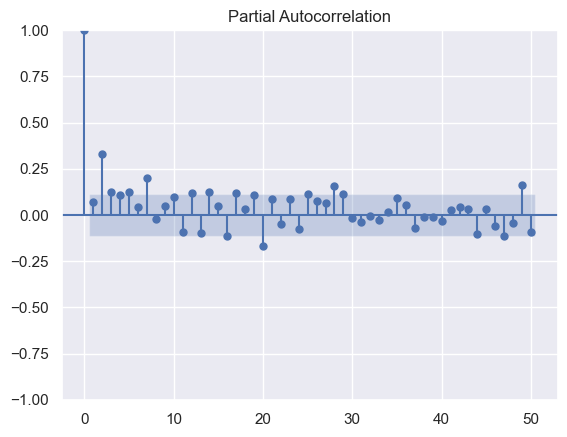

In [231]:
sm.graphics.tsa.plot_pacf(df4.values.squeeze(), lags=50)
plt.show()

Plotting Correlation Matrix
---

In [232]:
corr = df4.copy()
corr['lag_1'] = corr.steps.shift(1)
corr['lag_2'] = corr.steps.shift(2)
corr['lag_3'] = corr.steps.shift(3)
corr['lag_4'] = corr.steps.shift(4)
corr['lag_5'] = corr.steps.shift(5)
corr['lag_6'] = corr.steps.shift(6)
corr['lag_7'] = corr.steps.shift(7)
corr['lag_8'] = corr.steps.shift(8)
corr['lag_9'] = corr.steps.shift(9)
corr['lag_10'] = corr.steps.shift(10)


In [233]:
res = corr.corr()
res.style.background_gradient(cmap='coolwarm')

,steps,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
steps,1.000000,0.070160,0.333720,0.148021,0.211556,0.195488,0.149164,0.293933,0.078008,0.221150,0.168889
lag_1,0.070160,1.000000,0.070877,0.333621,0.147193,0.210833,0.197021,0.148289,0.293671,0.076952,0.221440
lag_2,0.333720,0.070877,1.000000,0.071244,0.336477,0.149755,0.209235,0.199654,0.149078,0.296625,0.076590
lag_3,0.148021,0.333621,0.071244,1.000000,0.070818,0.336557,0.150595,0.209065,0.199516,0.148763,0.296777
lag_4,0.211556,0.147193,0.336477,0.070818,1.000000,0.067373,0.341341,0.147495,0.208326,0.196498,0.149758
lag_5,0.195488,0.210833,0.149755,0.336557,0.067373,1.000000,0.071392,0.338806,0.146603,0.205198,0.197652
lag_6,0.149164,0.197021,0.209235,0.150595,0.341341,0.071392,1.000000,0.075335,0.340633,0.150943,0.204867
lag_7,0.293933,0.148289,0.199654,0.209065,0.147495,0.338806,0.075335,1.000000,0.074303,0.338067,0.151975
lag_8,0.078008,0.293671,0.149078,0.199516,0.208326,0.146603,0.340633,0.074303,1.000000,0.073234,0.338389
lag_9,0.221150,0.076952,0.296625,0.148763,0.196498,0.205198,0.150943,0.338067,0.073234,1.000000,0.074140


Stationarity
---
<br>
Stationarity implies that all moments (i.e., means, variances, covariances, lagged covariances, etc.) are invariant over time.
<br>
A time series is stationary when:
<br>
the mean is stable over time (i.e, no trend or cycle): mean-stationary
<br>
the variances and autocovariances are stable over time: covariance-stationary
<br>
Reasons for non-stationarity:
<br>
the process has a unit root (e.g., a random walk)
<br>
the process is characterized by a trend over time
<br>
the parameters (e.g., autoregressive parameter, intercept) change over time
<br>
Stationarity can be checked in R by performing an Augmented Dickey-Fuller (ADF) and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests.
<br>
Before running the tests, let’s insepct the time series another time

<Figure size 2000x2000 with 0 Axes>

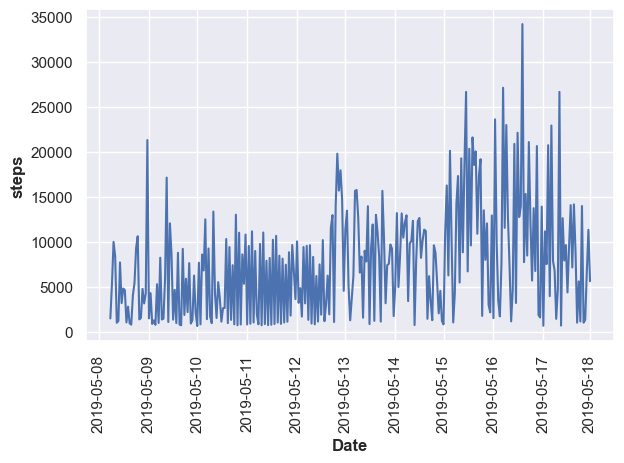

In [234]:
plt.figure(figsize=(20,20)) # this creates a figure 8 inch wide, 4 inch high

fig, ax = plt.subplots()
# plot with a horizontal orientation
sns.lineplot(x="Date", y="steps",data=df3)

# set the frequency for labelling the yaxis
freq = int(1)

# set the zlabels as the datetime data for the given labelling frequency,
# also use only the date for the label
ax.set_xticklabels(ts.iloc[::freq].Date.dt.date, rotation=90)
plt.tight_layout()
plt.show()

Test for unit root (e.g., random walk):
---
- The alternative hypothesis (H1) is: stationarity

In [269]:
result = sm.tsa.stattools.adfuller(df4, maxlag=6,autolag = "AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.394677
p-value: 0.011142
	1%: -3.453
	5%: -2.871
	10%: -2.572


Test for unit mean:
---
- The alternative hypothesis (H1) is: not mean-stationarity
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

In [284]:
result = sm.tsa.stattools.kpss(df4, regression='ct', nlags = 5)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
 print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.118970
p-value: 0.100000
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
